In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

In [64]:
path = kagglehub.dataset_download("brendan45774/test-file") 

In [65]:
print("Path to dataset files:", path)

Path to dataset files: /home/nurbol/.cache/kagglehub/datasets/brendan45774/test-file/versions/6


In [66]:
data = pd.read_csv("tested.csv") # I moved csv into current folder
data.info()
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [67]:
def preprocess_data(df):
    df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)

    df.drop(columns = ["Embarked"], inplace=True)
    df["Sex"] = df["Sex"].map({'male':1, "female":0})
    
    df["FamilySize"] = df["SibSp"] + df["Parch"]
    df["isAlone"] = np.where(df["FamilySize"] == 0, 1, 0)

    df['Pclass'] = df['Pclass'].astype(int)
 
    df['Fare'] = df['Fare'].fillna(0).astype(int)  
   
    fare_means = df.pivot_table('Fare', index='Pclass', aggfunc='mean')
    age_means = df.pivot_table('Age', index='Pclass', aggfunc='mean')
    
 
    df["Age"] = df[['Age', 'Pclass']].apply(
        lambda x: age_means.loc[x['Pclass']].values[0] if pd.isnull(x['Age']) else x['Age'], 
        axis=1
    )  
    print(df["Age"].isnull().sum())
    
    df["Fare"] = df[['Fare', 'Pclass']].apply(
        lambda x: fare_means.loc[x['Pclass']].values[0] if pd.isnull(x['Fare']) else x['Fare'], 
        axis=1
    )  
    
   
    df["FareBin"] = pd.qcut(df["Fare"], 4, labels=False)
    df["AgeBin"] = pd.cut(df["Age"], bins=[0, 12, 20, 40, 60, np.inf], labels=False)

    return df

In [68]:
data = preprocess_data(data)

0


In [69]:
data.info()
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    418 non-null    int64  
 1   Pclass      418 non-null    int64  
 2   Sex         418 non-null    int64  
 3   Age         418 non-null    float64
 4   SibSp       418 non-null    int64  
 5   Parch       418 non-null    int64  
 6   Fare        418 non-null    int64  
 7   FamilySize  418 non-null    int64  
 8   isAlone     418 non-null    int64  
 9   FareBin     418 non-null    int64  
 10  AgeBin      418 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 36.1 KB
Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
FamilySize    0
isAlone       0
FareBin       0
AgeBin        0
dtype: int64


In [72]:
X = data.drop(columns=["Survived"])
Y = data["Survived"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [73]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [77]:
#Hyperparameter Tuning - KNN 
def tun_mode(X_train, Y_train):
    param_grid = {
        "n_neighbors":range(1, 21), 
        "metric": ["euclidean", "manhattan", "minkowski"], 
        "weights": ["uniform", "distance"]
    }
    model = KNeighborsClassifier()
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    return grid_search.best_estimator_


In [78]:
best_model = tun_mode(X_train, Y_train)


In [80]:
def evaluate_model(model, X_test, Y_test):
    prediction = model.predict(X_test)
    accuracy = accuracy_score(Y_test, prediction)
    matrix = confusion_matrix(Y_test, prediction)
    return accuracy, matrix

In [83]:
accuracy, matrix = evaluate_model(best_model, X_test, Y_test)

print(f'accuracy_score: {accuracy*100:.2f}')
print('confusion_matrix: ')
print(matrix)

accuracy_score: 100.00
confusion_matrix: 
[[69  0]
 [ 0 36]]


In [85]:
#Plot model
def plot_model(matrix):
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt="d", xticklabels= ["Survived", "Not Survived"], yticklabels=["Not Survived", "Survived"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.ylabel("True Values")
    plt.show()

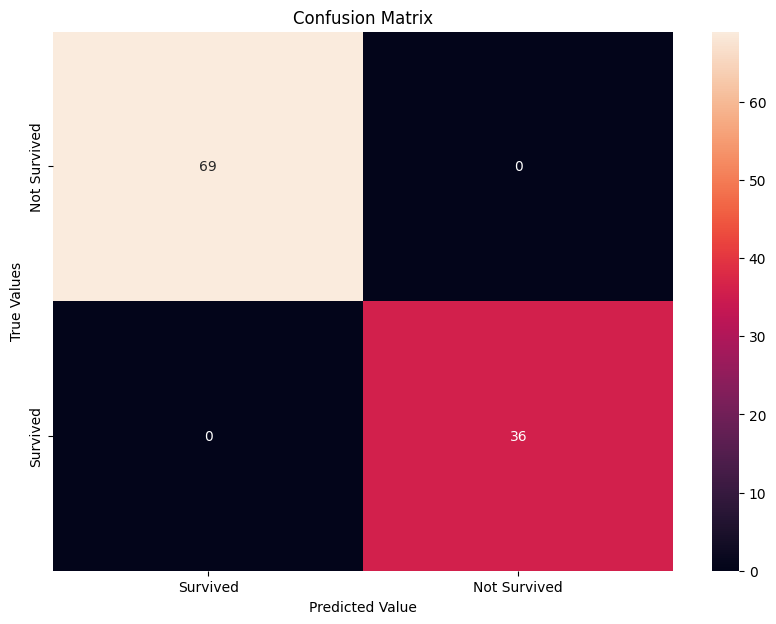

In [86]:
plot_model(matrix)